**LOADING REQUIRED LIBRARIES**

In [0]:
import pandas as pd 
from keras.models import Sequential,Model
from keras.layers import Embedding, SimpleRNN,Input
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense,Dropout
from keras.layers import Embedding, Flatten, Dense,Conv1D,MaxPooling1D, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns


**LOADING IMDB DATASET FOR TRAINING**

Dataset: containes 2 labels: positive and negative

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [0]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe

In [0]:
df2.head()

,text,sentiment
0,For a movie that gets no respect there sure ar...,0
1,Bizarre horror movie filled with famous faces ...,0
2,"A solid, if unremarkable film. Matthau, as Ein...",0
3,It's a strange feeling to sit alone in a theat...,0
4,"You probably all already know this by now, but...",0


In [0]:
data_inputs =  df2["text"].get_values()
data_labels = df2.sentiment

**TOKENIZE WORDS IN TRAIN TEXT DOCUMENT**

In [0]:
tokenizer = Tokenizer(nb_words=10000)
tokenizer.fit_on_texts(data_inputs)
sequences = tokenizer.texts_to_sequences(data_inputs)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)

labels = keras.utils.to_categorical(np.asarray(data_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 88565 unique tokens.
Shape of data tensor: (25000, 1000)
Shape of label tensor: (25000, 2)


**SPLIT DATA WITH 80:20 RATIO**

In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.20 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

**CREATING EMBEDDING MATRIX FROM PRETRAINED MODEL: GLOVE**

In [0]:
embeddings_index = {}
f = open( '/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [0]:

embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)


In [0]:
#y_val = y_val.flatten()
print(y_train.shape)
print(y_val.shape)

(20000, 2)
(5000, 2)


**MODEL CREATION**

In [0]:
def model_creation():
  input_layer = Input(shape=(1000,), dtype='int32')
  embed_layer = embedding_layer(input_layer)
  x = Conv1D(128, 5, activation='relu')(embed_layer)
  x = MaxPooling1D(5)(x)
  x = Conv1D(128, 5, activation='relu')(x)
  x = MaxPooling1D(5)(x)
  x = Conv1D(128, 5, activation='relu')(x)
  x = MaxPooling1D(35)(x)  # global max pooling
  x = Flatten()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(246, activation='relu')(x)
  final_layer = Dense(2, activation='softmax')(x)
  opt = keras.optimizers.Adam(lr= learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model = Model(input_layer,final_layer)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])
  return model 

In [0]:
learning_rate = 0.0001
batch_size = 32
epochs = 50
model_glove = model_creation()
model_glove.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 16s 798us/step - loss: 0.6561 - acc: 0.5922 - val_loss: 0.5432 - val_acc: 0.7350
Epoch 2/50
20000/20000 [==============================] - 13s 634us/step - loss: 0.4960 - acc: 0.7622 - val_loss: 0.4711 - val_acc: 0.7770
Epoch 3/50
20000/20000 [==============================] - 13s 633us/step - loss: 0.4220 - acc: 0.8114 - val_loss: 0.4713 - val_acc: 0.7852
Epoch 4/50
20000/20000 [==============================] - 13s 635us/step - loss: 0.3675 - acc: 0.8389 - val_loss: 0.4184 - val_acc: 0.8106
Epoch 5/50
20000/20000 [==============================] - 13s 634us/step - loss: 0.3254 - acc: 0.8615 - val_loss: 0.4311 - val_acc: 0.8218
Epoch 6/50
20000/2000

In [0]:
acc = model_glove.evaluate(x_val, y_val, verbose=1)
print('Test data loss:', acc[0] )
print('Test data accuracy:', acc[1] * 100)

5000/5000 [==============================] - 1s 261us/step
Test data loss: 1.0145598538398743
Test data accuracy: 81.3


**SAVE BEST MODEL AND WEIGHTS**

In [0]:
print("Saving model to disk \n")
mp = ".\\Models\\imdb_model.h5"
model_glove.save(mp)

Saving model to disk 



In [0]:
# serialize model to JSON
model_json = model_glove.to_json()
with open(".\\Models\\imdb_glove.h5", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_glove.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


**LOAD FINANCE DATA FOR TESTING ** 

In [0]:
edgar = pd.read_json("/content/earnings_call_ip_data_main.json")

In [0]:
edgar.head()

,sentiment,text
0,positive,"Thank you, Ellen. We have a strong 2018, with ..."
1,positive,Stock-based compensation totaled $2.3 billion....
10,negative,"For the full-year 2018, Other Bets revenues we..."
100,neutral,Great. Thank you. I just wanted to follow up o...
1000,negative,I have made it a priority to join Mike and Reb...


In [0]:
sent = {'positive': 1,'negative': 0,'neutral': 2} 
edgar.sentiment = [sent[item] for item in edgar.sentiment] 

In [0]:
data_inputs1 =  edgar["text"].get_values()
data_labels1 = edgar.sentiment

In [0]:
tokenizer = Tokenizer(nb_words=10000)
tokenizer.fit_on_texts(data_inputs1)
sequences = tokenizer.texts_to_sequences(data_inputs1)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)

labels = keras.utils.to_categorical(np.asarray(data_labels1))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 6392 unique tokens.
Shape of data tensor: (1649, 1000)
Shape of label tensor: (1649, 3)


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
# nb_validation_samples = int(.20 * data.shape[0])

# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

In [0]:
print(data.shape)
print(labels.shape)

(1649, 1000)
(1649, 3)


In [0]:
embeddings_index = {}
f = open( '/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:

embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)


In [0]:
x_train.shape

(20000, 1000)

Load Pre-Trained Model

In [0]:
from keras.models import load_model
pre_model = load_model.('.\\Models\\imdb_model.h5')
pre_model.add(Dense(3,activation='sigmoid'))

**LOAD SAVED MODEL **

In [0]:
from keras.models import model_from_json
# load json and create model
json_file = open(".\\Models\\imdb_glove.h5", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


**CUSTOMIZE OUTPUT LAYERS SINCE FINANCE DATA HAS 3 LABELS AND IMDB HAD 2 LABELS**

In [0]:
for layer in loaded_model.layers:
  layer.trainable = True

In [0]:

model1 = Sequential()
for layer in loaded_model.layers[:-1]:
    model1.add(layer)
    
model1.add(Dense(3,activation='softmax'))

In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         8856600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
__________

In [0]:
model1.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['acc'])

In [0]:
print('Test Evaluation with finance data')
evaluation = model1.evaluate(data,labels, batch_size=64)
print('Loss:', evaluation[0], 'Accuracy:', evaluation[1])

Test Evaluation with finance data
1649/1649 [==============================] - 1s 455us/step
Loss: 0.642773010645439 Accuracy: 0.6640388348595601


**MODEL PERFORMANCE ON FINANCE DATA** 

In [0]:
Prediction_glove = model1.predict(data)

In [0]:
for i in range(0,len(Prediction_glove)):
  y = Prediction_glove[i]
  max = np.argmax(y)
  min = np.argmin(y)
  for x in range(0,2):
    y[max]=1
    y[min]=0
    if y[x]!=0 and y[x]!=1:
      y[x]=0

**CONFUSION MATRIX**

In [0]:
cm = confusion_matrix(labels.argmax(axis=1), Prediction_glove.argmax(axis =1)) 
print('Confusion Matrix :')
print(cm) 

Confusion Matrix :
[[ 56   4  98]
 [258  26 376]
 [415  14 402]]


[]

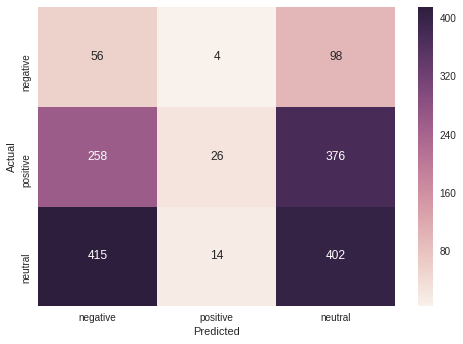

In [0]:
LABELS = ['negative', 'positive','neutral']
a = sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
a.set(xlabel='Predicted', ylabel='Actual')
a.plot()
# xl = plt.xlabel("Predicted")

# yl = plt.ylabel("Actual")